<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#实现" data-toc-modified-id="实现-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>实现</a></span><ul class="toc-item"><li><span><a href="#$kd$-树-和kNN" data-toc-modified-id="$kd$-树-和kNN-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>$kd$ 树 和kNN</a></span></li></ul></li><li><span><a href="#$kd$-树演示" data-toc-modified-id="$kd$-树演示-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>$kd$ 树演示</a></span><ul class="toc-item"><li><span><a href="#二维$kd$树结构" data-toc-modified-id="二维$kd$树结构-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>二维$kd$树结构</a></span></li><li><span><a href="#$kd$树查询" data-toc-modified-id="$kd$树查询-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>$kd$树查询</a></span></li></ul></li><li><span><a href="#kNN回归演示" data-toc-modified-id="kNN回归演示-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>kNN回归演示</a></span><ul class="toc-item"><li><span><a href="#1D" data-toc-modified-id="1D-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>1D</a></span></li><li><span><a href="#2D" data-toc-modified-id="2D-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>2D</a></span></li></ul></li></ul></div>

# 实现

## $kd$ 树 和kNN

In [1]:
import numpy as np


class KDTreeNode:
    def __init__(self, axis, index):
        self.axis = axis
        self.index = index
        self.left = None
        self.right = None

    def to_str(self, n_spaces=0):
        str_ = " " * (2 * n_spaces) + "(i=%d, a=%d)\n" % (self.index,
                                                          self.axis)
        if self.left is not None:
            str_ += self.left.to_str(n_spaces + 1)
        if self.right is not None:
            str_ += self.right.to_str(n_spaces + 1)
        return str_

    def get_children(self, depth=0):
        children = []
        if self.left is not None:
            children.extend(self.left.get_children(depth + 1))
        children.append((self, depth))
        if self.right is not None:
            children.extend(self.right.get_children(depth + 1))
        return children

    def __repr__(self):
        return self.to_str()


class KDTree:
    def __init__(self, X, metric = None):
        self.X = X
        if metric is None:
            metric = KDTree.dist2
        self.metric = metric

        self.root_node = self.MakeKDTree(np.arange(len(X)), X, 0)
        self.lower_bound = np.min(X, axis=0)
        self.upper_bound = np.max(X, axis=0)

    @staticmethod
    def dist2(x1, x2):
        dx = x1 - x2
        return np.dot(dx, dx)

    def MakeKDTree(self, indices, X, depth=0):

        if len(indices) == 0:
            return None

        #print("depth%d"%depth)
        axis = depth % X.shape[-1]

        # O(n) median finding algorithm is possible here
        x = X[indices, axis]
        argsort = np.argsort(x)
        indices = indices[argsort]

        n = len(indices)
        n = n // 2
        #print(n)

        node = KDTreeNode(axis=axis, index=indices[n])
        node.left = self.MakeKDTree(indices[0:n], X, depth + 1)
        node.right = self.MakeKDTree(indices[n + 1:], X, depth + 1)
        return node

    def k_neighbors_recr(self, node, x, k_index, k_distance, start, end, lower_bound, upper_bound):
        # update kn[start,end)
        assert node is not None

        #index = node.index
        #print("index", index)
        #print("lower bound", lower_bound)
        #print("upper bound", upper_bound)

        # minimum distance^2 of x to the bounds
        xp = np.where(x > upper_bound, upper_bound, np.where(x < lower_bound, lower_bound, x))
        d2 = self.metric(x, xp)
        for n in range(end-1, start-1, -1):
            if d2 >= k_distance[n]:
                n += 1
                break
        start = n

        if start == end:
            return

            
        axis = node.axis
        index = node.index
        x_split = self.X[index]


        if x[axis] < x_split[axis]:
            if node.left is not None:
                old = upper_bound[axis]
                upper_bound[axis] = x_split[axis]
                self.k_neighbors_recr(node.left, x, k_index, k_distance, start, end, lower_bound, upper_bound)
                upper_bound[axis] = old
        else:
            if node.right is not None:
                old = lower_bound[axis]
                lower_bound[axis] = x_split[axis]
                self.k_neighbors_recr(node.right, x, k_index, k_distance, start, end, lower_bound, upper_bound)
                lower_bound[axis] = old

        # try inserting x_split

        if (x[axis] - x_split[axis])**2 >= k_distance[end-1]:
            return

        dist2 = self.metric(x, x_split)

        #print("x", x)
        #print("index:", index)
        #print("x_split:", x_split[start:end])
        #print("dist2", dist2)

        #print("kn before insert", k_index)
        #print("kn before insert", k_distance)

        n =  end - 1
        if dist2 < k_distance[n]:
            while n > start:
                if k_distance[n-1] <= dist2:
                    break

                k_index[n] = k_index[n-1]                
                k_distance[n] = k_distance[n-1]                
                n -= 1

            k_index[n] = index
            k_distance[n] = dist2
            

        #print("kn after  insert", k_index)
        #print("kn after  insert", k_distance)

        if x[axis] < x_split[axis]:
            if node.right is not None:
                old = lower_bound[axis]
                lower_bound[axis] = x_split[axis]
                self.k_neighbors_recr(node.right, x, k_index, k_distance, start, end, lower_bound, upper_bound)
                lower_bound[axis] = old
        else:
            if node.left is not None:
                old = upper_bound[axis]
                upper_bound[axis] = x_split[axis]
                self.k_neighbors_recr(node.left, x, k_index, k_distance, start, end, lower_bound, upper_bound)
                upper_bound[axis] = old
                
            
    def query(self, X, k):
        k_index = np.full(k, -1, dtype=np.int_)
        k_distance = np.full(k, np.inf)
        lower_bound = self.lower_bound
        upper_bound = self.upper_bound

        if k > 0:
            root_node = self.root_node
            if root_node is not None:
                self.k_neighbors_recr(node=root_node, x=X,\
                    k_index=k_index, k_distance=k_distance, start=0, end=k, lower_bound=lower_bound, upper_bound=upper_bound)
                
        assert np.all(k_index >= 0)
        assert np.all(np.isfinite(k_distance))
        return k_distance, k_index


class KNeighborsRegressor:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.kdtree = KDTree(X)
        
    def predict(self, X):
        
        yhat = np.zeros(X.shape[0])
        n_neighbors = self.n_neighbors
        for i, x_ in enumerate(X):
            dist, ind = self.kdtree.query(x_,n_neighbors)
            yhat[i] = self.y[ind].mean()
            
        return yhat
    
    

# $kd$ 树演示

## 二维$kd$树结构

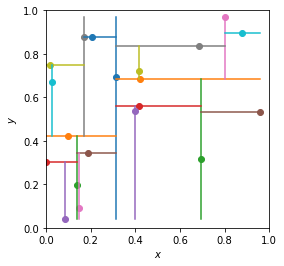

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(tree, node=None, depth=0, box=None, ax=None):
    if ax is None:
        import matplotlib.pyplot as plt
        ax = plt.gca()

    if box is None:
        lb = tree.lower_bound
        ub = tree.upper_bound
        box = (lb[0], lb[1], ub[0], ub[1])
    
    if node is None:
        node = tree.root_node

    X = tree.X
    axis = node.axis
    index = node.index
    if axis == 0:
        x = X[index, axis]
        y = X[index, 1-axis]
        
        ax.plot([x, x], [box[1], box[3]])
        ax.scatter([x], [y])
        boxLeft = (box[0], box[1], x, box[3])
        boxRight = (x, box[1], box[2], box[3])
        if node.left is not None:
            plot(tree, node=node.left, depth=depth+1, box=boxLeft, ax = ax)
            pass
        if node.right is not None:
            plot(tree, node=node.right, depth=depth+1, box=boxRight, ax = ax)
            pass
    else:
        y = X[index, axis]
        x = X[index, 1-axis]
        ax.plot([box[0], box[2]], [y, y])
        ax.scatter([x], [y])
        boxLower = (box[0], box[1], box[2], y)
        boxUpper = (box[0], y, box[2], box[3])
        if node.left is not None:
            plot(tree, node=node.left, depth=depth+1, box=boxLower, ax = ax)
            pass
        if node.right is not None:
            plot(tree, node=node.right, depth=depth+1, box=boxUpper, ax = ax)
            pass
        
        
        
np.random.seed(1)
X = np.random.rand(20, 2)
tree = KDTree(X)

plt.figure(figsize=(4,4))
plt.xlim((0,1))
plt.ylim((0,1))
plot(tree, ax=plt.gca())
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()


## $kd$树查询

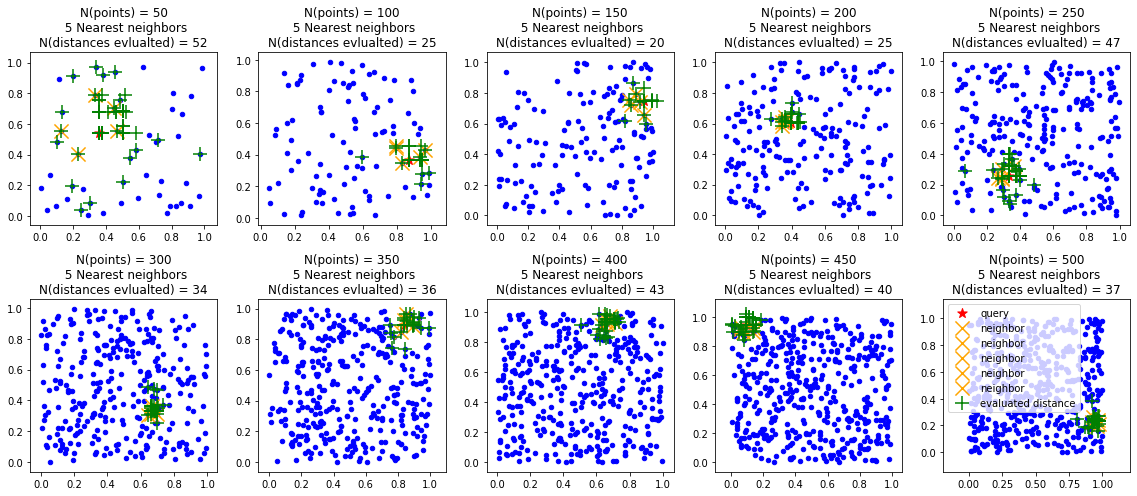

In [17]:


measured = []
def metric(x, xp):
    measured.append(xp)
    dx = x - xp
    return dx.dot(dx)



fig, axes = plt.subplots(2,5, figsize=(16,7))
for i in range(10):
    
    X = np.random.rand((i+1)*50, 2)
    Npoints = X.shape[0]
    
    tree = KDTree(X, metric=metric)

    ax = axes[i//5, i%5]
    query = np.random.rand(2)

    measured.clear()
    dist, ind = tree.query(query, 5)

    ax.scatter(query[0], query[1], marker="*", s=100, c='red', label="query")
    for i in range(len(X)):
        ax.scatter(X[i,0], X[i,1], s=20, c="blue")
    for i in ind:
        ax.scatter(X[i,0], X[i,1], marker="x", s=200, c='orange', label="neighbor")
    for i, x in enumerate(measured):
        if i == 0:
            ax.scatter(x[0], x[1], marker="+", s=200, c="green", label="evaluated distance")
        else:
            ax.scatter(x[0], x[1], marker="+", s=200, c="green")
    ax.set_title("N(points) = %d\n 5 Nearest neighbors\nN(distances evlualted) = %2d"% (Npoints, len(measured)))

plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# kNN回归演示

## 1D

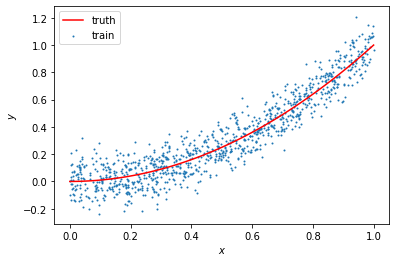

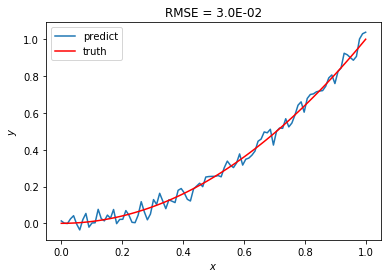

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def f(X):
    return X[:,0]**2
X = np.random.rand(1000, 1)
y = f(X) + 0.1*np.random.randn(1000)
X_plt = np.linspace(0,1,100)


plt.scatter(X[:,0], y, label="train", s=1)
plt.plot(X_plt, f(X_plt.reshape(-1,1)), label="truth", color="r")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

knr = KNeighborsRegressor(n_neighbors=10)
knr.fit(X, y)
yhat = knr.predict(X_plt.reshape(-1,1))


RMSE = np.sqrt(np.square(yhat - f(X_plt.reshape(-1,1))).mean())
plt.title("RMSE = %.1E"%RMSE)
plt.plot(X_plt, yhat, label="predict")
plt.plot(X_plt, f(X_plt.reshape(-1,1)), label="truth", color="r")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

## 2D

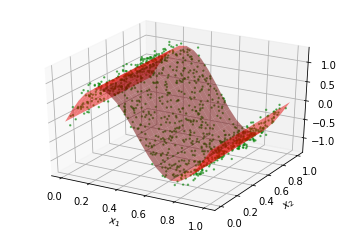

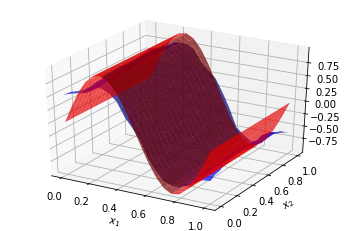

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def g(X):
    return  np.sin(2*np.pi*X[:,0])
X = np.random.rand(1000, 2)
y = g(X) + 0.1*np.random.randn(1000)


N_plt = 20
X_plt = np.linspace(0,1,N_plt)
xx, yy = np.meshgrid(X_plt, X_plt)

ax = plt.subplot(1,1,1, projection="3d")
ax.scatter(X[:,0], X[:,1], y, alpha=0.5, s=2, c="g")
ax.plot_surface(xx, yy, g(np.c_[xx.ravel(), yy.ravel()]).reshape(N_plt,N_plt), color="r", alpha=0.5)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.show()

ax = plt.subplot(1,1,1, projection="3d")
knr = KNeighborsRegressor(n_neighbors=50)
knr.fit(X, y)
yhat = knr.predict(np.c_[xx.ravel(), yy.ravel()])

y1 = yhat.reshape(N_plt,N_plt)
y2 = g(np.c_[xx.ravel(), yy.ravel()]).reshape(N_plt,N_plt)
ax.plot_surface(xx, yy, y1, color="blue", label="predict", alpha=0.7)
ax.plot_surface(xx, yy, y2, color="red", label="truth", alpha=0.7)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
#ax.legend()
plt.show()
